## Set-up
* importing necessary packages and defining parameters

In [3]:
import numpy as np
import cv2
import math 
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from matplotlib import colors
from scipy.signal import argrelextrema
import pandas as pd
import csv
import os
from scipy.ndimage import gaussian_filter1d
import re

In [4]:
extension_factor = 1.1
step_size = 2
max_width = 2048
overlap_threshold = 0.3
weight_epithelium_coverage = 0.8
weight_background_pixels = 0.2
sigma_factor = 20

## *** IMPORTANT *** 
This code relies on the slice images and masks being in a folder called `testing_slices/`

Inside that folder, create a folder called `patch_outputs/` for the patches to be exported into

In [6]:
image_folder = './testing_slices'
image_files = [f for f in os.listdir(image_folder) if f.startswith('h&e')]

## Updated patching code

In [8]:
def estimate_curvature_complexity(points):
    """
    Estimate complexity of a contour based on curvature variations.
    """

    if len(points)<5:
        return 1
    
    diffs=np.gradient(points, axis=0)
    curvature=np.linalg.norm(np.gradient(diffs,axis=0),axis=1)

    # Count number of local maxima in curvature (sharp points)
    peaks=argrelextrema(curvature, np.greater)[0]
    
    #Return peaks/points for rough approx of sharp changes
    return len(peaks)/len(points)

In [158]:

def find_external_contours(binary_image):
    '''find all external contours of an image'''

    contours,hierarchy=cv2.findContours(binary_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    #This can be used to alter the order contour points are processed in while maintaining order
        #Think [1,2,3,4,5]->[4,5,1,2,3]
        #Set to 0 for no effect, check np documentation for more info
    return [np.roll(contour,0,axis=0) for contour in contours if len(contour)>1]

def find_all_contours(binary_image, min_area=500):
    """
    Find external contours from a binary image with increased sensitivity.
    Theoretically could cross refence the contour of the entire sample to the contour of the epithelium to determine exterior v. stroma
    """
    # Optional Gaussian blur to smooth small details
    blurred = cv2.GaussianBlur(binary_image, (5, 5), 0)

    # Morphological operations to remove small objects and fill gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    cleaned = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel, iterations=2)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find external contours
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter by area
    return [np.roll(c, 0, axis=0) for c in contours if cv2.contourArea(c) >= min_area]


def gaussian_normals(contours):
    #Initialize list for final normals
    all_normals=[]
    smooth=[]

    #Loop through all contours
    for contour in contours:
        #Reshape contour into point pairings
        points=contour.reshape(-1,2).astype(np.float32)
        
        #Define sigma paramter(std for Gaussian Kernel from contour length)
        #Higher value of sigma means more aggressive smoothing
        #sigma,smoothed=estimate_sigma(points,1,1e-5,60)
        sigma=max(len(contour)*estimate_curvature_complexity(points)//sigma_factor,1)
        smoothed=gaussian_filter1d(points,sigma,axis=0, truncate = 100)
        print(f'Sigma of : {sigma}')
        #Apply Gaussian smoothing to X and Y values, attempting to remove noise from the contour
        #smoothed=np.apply_along_axis(lambda x: gaussian_filter1d(x,sigma,mode='reflect'),axis=0,arr=points)
        #Calculate gradients of X and Y for use then finding the tangent
        gradients=np.gradient(smoothed,axis=0)
        #Find vector norms of tangent vectors
        all_norms=np.linalg.norm(gradients,axis=1,keepdims=True)
        #Divide tangents by norms with numerical stability
        tangent_unit=gradients/(all_norms+1e-8)
        #Initialize normals
        normals=np.zeros_like(tangent_unit)
        
        normals = np.column_stack((-tangent_unit[:, 1], tangent_unit[:, 0]))
        all_normals.append(normals)
        smooth.append(smoothed.reshape(-1,1,2).astype(np.int32))

    return all_normals,smooth


def calculate_patch_corners(point, normal, binary_image, extension_factor=1.0, step_size=4, max_length=2048):
    """
    Calculate the corners of a square patch using epithelium width along the normal.

    Args:
        point (np.ndarray): The point on the contour.
        normal (np.ndarray): The normal vector at the point.
        binary_image (np.ndarray): Binary mask of the tissue.
        extension_factor (float): Factor to slightly enlarge the patch (e.g., 1.1 for 10% increase).
        step_size (int): Step size for checking tissue boundaries along the normal.
        max_length (int): Maximum distance to search for epithelium width.

    Returns:
        np.ndarray: The four corners of the square patch.
        int: The computed patch height.
    """
    height, width = binary_image.shape
    point = point.astype(int)

    # generating forward and backward points along the normal
    steps = np.arange(0, max_length, step_size)[:, None]
    points = np.clip(point - steps * normal, 0, [width - 1, height - 1]).astype(int)

    # extracting pixel values along the normal path
    values = binary_image[points[:, 1], points[:, 0]]

    # finding the first background pixel (where value == 0)
    stop = np.where(values == 0)[0]

    # computing distances
    width = stop[0] * step_size if stop.size > 0 else max_length

    # computing total epithelium width and adjust for stroma extension
    extended_length = int(width * extension_factor)
    half_size = extended_length // 2 

    # computing tangent vector (perpendicular to normal)
    tangent = np.array([-normal[1], normal[0]])

    # defining square corners (same logic as `calculate_square_corners`)
    corners = np.array([
        point + (tangent * half_size),
        point - (tangent * half_size),
        point - (tangent * half_size) - (normal * extended_length),
        point + (tangent * half_size) - (normal * extended_length)
    ])

    return corners, extended_length


def calculate_square_overlap(square1,square2):
    '''Calculate overlap ratio between squares'''

    square1=Polygon(square1)
    square2=Polygon(square2)

    if not square1.intersects(square2):
        return 0
    
    intersection_area=square1.intersection(square2).area
    smallest_area=min(square1.area,square2.area)
    return intersection_area/(smallest_area+1e-8)

###
###
###

def patch_score(patch, mask):
    """
    Compute the standardized patch score as a ratio of epithelium pixels (255)
    to total pixels inside the polygon defined by the mask.
    """
    # Only count pixels where the mask is 255 (i.e., inside the polygon)
    inside_polygon = (mask == 255)

    if np.count_nonzero(inside_polygon) == 0:
        return 0.0  # Avoid division by zero

    epithelium_pixels = np.sum((patch == 255) & inside_polygon) # pixels that are epithelium
    total_pixels = np.count_nonzero(inside_polygon) # all pixels

    score = epithelium_pixels / total_pixels # percent of pixels in the patch that are epithelium (higher ratio, better patch)
    return score  # value between 0.0 and 1.0

def patch_score2(patch, mask):
    """
    Compute the standardized patch score as a ratio of epithelium pixels (255)
    to total pixels inside the polygon defined by the mask.
    """
    score = np.mean(patch) # percent of pixels in the patch that are epithelium (higher ratio, better patch)
    return score  # value between 0.0 and 1.0
    
def extract_patch(image, corners):
    """
    Extract the patch defined by 4 corners.
    Returns only the pixel values of the mask within the polygon defined by the corners.
    """
    mask = np.zeros(image.shape, dtype=np.uint8)

    # Ensure corners are integer coordinates
    polygon = np.array([corners], dtype=np.int32)

    # Fill the polygon on the mask
    cv2.fillPoly(mask, polygon, 255)

    # Apply the mask to the image
    patch = cv2.bitwise_and(image, image, mask=mask)

    return patch

def create_smarter_squares(contours,normals,binary_image,overlap_thresh):
    '''Create squares that meet overlap thresh with last square'''
    return_squares=[]
    #Loop over all contours and get corresponding normals to point
    for contour, contour_normals in zip(contours,normals):
        points=contour.reshape(-1,2)
        squares=[]
        curr_square_area = np.zero binary_image
        # last_square=None

        #Go over points, evaluating if next square's corner falls outside of range of last square
        for i,point in enumerate(points):

            corners,length=calculate_patch_corners(point,contour_normals[i],binary_image)

            #Prevent poorly sized squares
            #Finding rough area approximation in terms of patch length
            side_length = np.sqrt(cv2.contourArea(contour))
            
            #Approximately: Want squares less than 50% of contour area, and minimum of 2% area
            if length<side_length*0.02 or length>side_length*0.5:
                continue
                
            #Check to see if first square and check agaisnt last square to prevent long loop
            elif last_square is not None and calculate_square_overlap(last_square,corners)>overlap_thresh:
                if Polygon(last_square).area>Polygon(corners).area and calculate_square_overlap(last_square,corners)>.98:
                    squares[-1]=corners
                    last_square=corners
                    continue
                continue

            #Check agasint all squares, prevents issues of larger patches covering thin sections of epithelium next to large ones 
            elif any(calculate_square_overlap(corners, square)>overlap_thresh for square in squares)==True:
                continue

            squares.append(corners)
            last_square=corners
            
        return_squares.append(squares)
    return return_squares

def create_smarter_squares_V2(contours, normals, binary_image, overlap_thresh=0.3):
    """
    Return high-scoring, non-overlapping patches using binary_image as epithelium mask.\
    
    """
    from shapely.geometry import Polygon
    import numpy as np
    import cv2

    epithelium_mask_2D = binary_image.copy()
    weight_epithelium_coverage = 1.0
    weight_background_pixels = 0.0

    all_scored_patches = []

    for contour, contour_normals in zip(contours, normals):
        points = contour.reshape(-1, 2)
        side_length = np.sqrt(cv2.contourArea(contour))

        for i, point in enumerate(points):
            corners, length = calculate_patch_corners(point, contour_normals[i], binary_image)
            if length < side_length * 0.02:
                continue

            score = patch_score(corners)
            all_scored_patches.append((corners, score))

    # Sort patches by score in descending order
    all_scored_patches.sort(key=lambda x: x[1], reverse=True)
    print(len(all_scored_patches))

    # Select patches with low overlap
    final_patches = []

    for patch, _ in all_scored_patches:
        if all(calculate_square_overlap(patch, existing) < overlap_thresh for existing in final_patches):
            final_patches.append(patch)

    return final_patches



def create_smarter_squares_V3(contours, normals, binary_image, overlap_thresh=0.3, max_patches=None):
    """
    Return high-scoring, non-overlapping patches using binary_image as epithelium mask.
    """
    all_scored_patches = []

    # Precompute side lengths
    for contour, contour_normals in zip(contours, normals):
        points = contour.reshape(-1, 2)
        area = cv2.contourArea(contour)
        if area <= 0:
            continue

        side_length = np.sqrt(area)

        for i, point in enumerate(points):
            corners, length = calculate_patch_corners(point, contour_normals[i], binary_image)

            if length < side_length * 0.02:
                continue

            score = patch_score(corners)
            all_scored_patches.append((np.array(corners), score))

    # Sort patches by descending score
    all_scored_patches.sort(key=lambda x: x[1], reverse=True)
    print(f"Candidate patches: {len(all_scored_patches)}")

    final_patches = []
    bboxes = []

    for patch, _ in all_scored_patches:
        x_coords = patch[:, 0]
        y_coords = patch[:, 1]
        bbox = (x_coords.min(), y_coords.min(), x_coords.max(), y_coords.max())

        # Fast rejection using bounding boxes
        overlaps = False
        for existing_bbox in bboxes:
            if compute_bbox_iou(bbox, existing_bbox) >= overlap_thresh:
                overlaps = True
                break

        if not overlaps:
            final_patches.append(patch)
            bboxes.append(bbox)
            if max_patches and len(final_patches) >= max_patches:
                break

    return final_patches

def compute_bbox_iou(bbox1, bbox2):
    """Fast bounding box IoU for square-like regions (x_min, y_min, x_max, y_max)"""
    xA = max(bbox1[0], bbox2[0])
    yA = max(bbox1[1], bbox2[1])
    xB = min(bbox1[2], bbox2[2])
    yB = min(bbox1[3], bbox2[3])

    inter_area = max(0, xB - xA) * max(0, yB - yA)
    if inter_area == 0:
        return 0.0

    box1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    box2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

def create_smarter_squares_V4(contours, normals, binary_image, overlap_thresh):
    '''
    Create squares that meet overlap threshold with already accepted squares
    Instead of checking against last square or iterating through all squares, 
    maintain a mask of the area already covered by squares to check the overlap
    with potential new squares
    '''
    return_squares = []
    curr_square_area = np.zeros_like(binary_image, dtype=np.uint8)

    for contour, contour_normals in zip(contours, normals):
        points = contour.reshape(-1, 2)

        for i, point in enumerate(points):
            corners, length = calculate_patch_corners(point, contour_normals[i], binary_image)

            # Prevent poorly sized squares
            side_length = np.sqrt(cv2.contourArea(contour))
            if length < side_length * 0.02 or length > side_length * 0.5:
                continue

            # Create mask for the proposed square
            square_mask = np.zeros_like(binary_image, dtype=np.uint8)
            corners_int = np.round(corners).astype(np.int32)
            cv2.fillConvexPoly(square_mask, corners_int, 1)

            # Calculate overlap with current accepted region
            overlap_area = np.logical_and(curr_square_area, square_mask).sum()
            proposed_area = square_mask.sum()

            # Accept if overlap is less than threshold ratio
            if proposed_area == 0 or (overlap_area / proposed_area) > overlap_thresh:
                continue

            # Add to list and update current square area
            return_squares.append(corners)
            curr_square_area = np.logical_or(curr_square_area, square_mask).astype(np.uint8)

    return return_squares

###
###
###


def draw_squares(image,squares_list,color=[255,0,0],thickness=20):
    '''Draw squares on image'''

    result=image.copy()

    for squares in squares_list:
        for square in squares:
            points=square.astype(np.int32)
            cv2.polylines(result,[points],isClosed=True,color=color,thickness=thickness)
        
    return result

# Function to draw patches
def draw_patches(image, patch_list, color = [255,0,0], thickness = 20):
    patches_on_slice = image.copy()
    for squares in patch_list:
        for square in squares:
            points=square.astype(np.int32)
            cv2.polylines(patches_on_slice,[points],isClosed=True,color=color,thickness=thickness)
    return patches_on_slice



def process_contours(image,binary_image,overlap_thresh=0.3):
    """
    Main function to process multiple contours and generate aligned squares along them.
    
    Args:
        image (np.ndarray): Original image
        binary_image (np.ndarray): Binary mask of the shapes
        overlap_thresh (float): Maximum allowed overlap between squares        
    Returns:
        tuple: (processed image, contours, squares_list)
    """
    contours=find_external_contours(binary_image)
    if not contours:
        return TypeError('No contours found')
    
    #Condition check for square creation
    #normals=calculate_contour_normals(contours,smoothing_size)
    normals,smooth=gaussian_normals(contours)
    #normals,smooth=fourier_normals(contours,0.999)
    final_squares_list=create_smarter_squares(contours,normals,binary_image,overlap_thresh=overlap_thresh)
    tissue_slice = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    
    result = draw_squares(tissue_slice,final_squares_list)
    #Visualzie smoothed contour

    try:
        cv2.drawContours(result,smooth,-1,(0,255,0),30)
    except:
        print('No smoothed contour to show')
    
    return result, contours, final_squares_list, normals



def process_all_contours(image,binary_image,overlap_thresh=0.3):
    """
    Main function to process multiple contours and generate aligned squares along them.
    
    Args:
        image (np.ndarray): Original image
        binary_image (np.ndarray): Binary mask of the shapes
        overlap_thresh (float): Maximum allowed overlap between squares        
    Returns:
        tuple: (processed image, contours, squares_list)
    """
    contours=find_all_contours(binary_image)
    if not contours:
        return TypeError('No contours found')
    
    #Condition check for square creation
    #normals=calculate_contour_normals(contours,smoothing_size)
    normals,smooth=gaussian_normals(contours)
    #normals,smooth=fourier_normals(contours,0.999)
    final_squares_list=create_smarter_squares(contours,normals,binary_image,overlap_thresh=overlap_thresh)
    tissue_slice = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    
    result = draw_squares(tissue_slice,final_squares_list)
    #Visualzie smoothed contour

    try:
        cv2.drawContours(result,smooth,-1,(0,255,0),30)
    except:
        print('No smoothed contour to show')
    
    return result, contours, final_squares_list, normals


In [10]:
# Carried over functions

def empty_folder():
    # delete everything out of directory
    output_folder = 'testing_slices/patch_outputs'
    if not os.path.exists(output_folder):  # Check if folder exists
        os.makedirs(output_folder)  # Create folder if it doesn't exist
    for file in os.listdir(output_folder):
        file_path = os.path.join(output_folder, file)
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            os.rmdir(file_path)

# Export patched slice into a new folder 
def export_patched_slice(patched_slice_name, selected_patches_on_slice):

    output_folder = os.path.join('testing_slices', 'patch_images')
    if not os.path.exists(output_folder):  # Check if folder exists
        os.makedirs(output_folder)  # Create folder if it doesn't exist

    output_path = os.path.join(output_folder, os.path.basename(patched_slice_name))
    cv2.imwrite(output_path, cv2.cvtColor(selected_patches_on_slice, cv2.COLOR_RGB2BGR))

# Calculate performance metrics
def calculate_metrics(epithelium_mask_2D, all_selected_patches):

    num_patches = len(np.vstack(all_selected_patches))

    total_epithelium_pixels = (epithelium_mask_2D > 0).sum()
    patch_mask = np.zeros_like(epithelium_mask_2D, dtype=np.uint8)

    #For all patches in all contours, use them to create a mask
    for contour_patches in all_selected_patches:
        for patch in contour_patches:
            patch = np.array(patch,dtype = np.int32).reshape(-1, 1, 2)
            cv2.fillPoly(patch_mask, [patch], 255)

    number_of_patch_mask_pixels = np.count_nonzero(patch_mask > 0)

    covered_epithelium_pixels = np.count_nonzero((patch_mask > 0) & (epithelium_mask_2D > 0))
    covered_background_pixels = np.count_nonzero((patch_mask > 0) & (epithelium_mask_2D == 0))

    total_epithelium_coverage = (covered_epithelium_pixels / total_epithelium_pixels*100)
    background_pixel_percent = (covered_background_pixels / number_of_patch_mask_pixels*100)
    score = weight_epithelium_coverage*total_epithelium_coverage + weight_background_pixels*(100 - background_pixel_percent)

    # Exporting performance metrics and parameter values
    metrics = pd.DataFrame({'Metric':['num_patches','total_epithelium_coverage', 'background_pixel_percent',
                        'score', 'extension_factor', 'step_size',
                        'max_width', 'overlap_threshold'], 
                'Value':[num_patches, total_epithelium_coverage, background_pixel_percent, score, 
                        extension_factor, step_size, max_width, overlap_threshold]})

    return metrics

def find_edges(all_selected_patches):
    all_points = np.vstack(all_selected_patches[0])

    edges = {'min_x': np.min(all_points[:, 0]),
             'max_x': np.max(all_points[:, 0]),
             'min_y': np.min(all_points[:, 1]),
             'max_y': np.max(all_points[:, 1])}

    return edges

def add_padding(image, edges):
        
    height, width, channels = image.shape

    if edges['min_x'] < 0:
        left = math.ceil(np.abs(edges['min_x']))
    else: left = 0

    if edges['max_x'] > width:
        right = math.ceil(edges['max_x'] - width)
    else: right = 0

    if edges['min_y'] < 0:
        top = math.ceil(np.abs(edges['min_y']))
    else: top = 0

    if edges['max_y'] > height:
        bottom = math.ceil(edges['max_y'] - height)
    else: bottom = 0

    new_width = width + right + left
    new_height = height + top + bottom
    

    # compute the padding color using the mode pixel value
    threshold = 15
    mask = np.all(image>threshold, axis = -1)
    if np.any(mask):
        bright_pixels = image[mask]
        if np.issubdtype(image.dtype,np.integer):
            dims = (np.iinfo(image.dtype).max + 1,) * channels
            combined = np.ravel_multi_index(bright_pixels.T,dims)
            unique_vals, counts = np.unique(combined, return_counts = True)
            mode_val = unique_vals[np.argmax(counts)]
            mode_color = np.array(np.unravel_index(mode_val, dims)).astype(image.dtype)
            pad_color = mode_color.flatten()
        else:
            pixels, counts = np.unique(bright_pixels, axis = 0, return_counts = True)
            pad_color = pixels[np.argmax(counts)]
    else:
        pad_color = np.array([threshold] * channels , dtype = image.dtype)


    padded_image = np.ones((new_height, new_width, channels), dtype=image.dtype) * pad_color

    # Insert the original image into the array of updated dimensions
    padded_image[top:top + height, left:left + width] = image


    return padded_image, right, left, top, bottom

# Shift patches by padding amount
def shift_patches(padded_image, all_selected_patches, left, top):

    all_points = np.vstack(all_selected_patches)

    shift_x = left
    shift_y = top
    shift_array = np.array([shift_x, shift_y])
    shifted_points = all_points + shift_array
    shifted_points = np.vstack(shifted_points)
    shifted_points = np.split(shifted_points, len(shifted_points) // 4)
    shifted_points = [shifted_points]   

    shifted_patches_on_slice = draw_patches(padded_image, shifted_points)

    return shifted_patches_on_slice, shifted_points

# edited to 
def show_shifted_patches(image, padded_image, all_selected_patches, shifted_patches_on_slice, binary_image):
    # Convert grayscale mask to RGB for overlaying patches
    mask_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)

    # Plot the original image and the patched mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    result = draw_patches(image,all_selected_patches)
    mask = draw_patches(mask_rgb,all_selected_patches)
    #mask = mask_rgb
    axes[0].imshow(result)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask)
    axes[1].set_title("Grayscale Mask with Patches")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
    result = cv2.hconcat([result,mask])
    return result


def extract_square_images(image, points):
    
    patch_images = []
    square_list = np.vstack(points)

    for square in square_list:

        # create an empty mask with white inside just the square's region
        square = square.astype(np.int32)
        square.reshape((-1,1,2)) # bc cv2.fillpoly expects points to be in shape (N,1,2)
        mask = np.zeros(image.shape[:2],dtype = np.uint8)
        cv2.fillPoly(mask, [square], 255)

        # Apply the mask to the image
        masked_image = cv2.bitwise_and(image, image, mask = mask)

        # uncomment to see placement of patch within the entire slice image 
        # plt.imshow(masked_image)
        # plt.show()

        # Crop the image around the rotated square (will have black space due to rotation)
        x_min = np.min(square[:, 0])
        x_max = np.max(square[:, 0])
        y_min = np.min(square[:, 1])
        y_max = np.max(square[:, 1])
        cropped_image = masked_image[y_min:y_max, x_min:x_max]

        # rotate the cropped image to be parallel to the xy axis
        # calculate the angle the patch needs to be rotated by
        point1 = square[0]  # top-left corner
        point2 = square[1]  # top-right corner
        vector = point2 - point1
        angle_degrees = np.arctan2(vector[1], vector[0]) * (180.0 / np.pi) - 180

        # Get the center of the cropped image
        center = (int((x_max - x_min)) // 2, int((y_max - y_min)) // 2)

        # Create the rotation matrix to rotate around the center
        rotation_matrix = cv2.getRotationMatrix2D(center, angle_degrees, 1.0) # 1.0 means image wont be scaled

        # Rotate the cropped image to make it parallel to xy axis
        if cropped_image.shape[0] > 0 and cropped_image.shape[1] > 0:
            rotated_patch = cv2.warpAffine(cropped_image, 
                                        rotation_matrix,
                                        (cropped_image.shape[1], cropped_image.shape[0]))  # output image size
        else:
            print("Cropped image is empty, skipping rotation.")

        # remove the extra black pixels around the edges
        gray = cv2.cvtColor(rotated_patch, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])
        cropped_img = rotated_patch[y:y+h, x:x+w]

        patch_images.append(cropped_img)
    
    return patch_images

def save_patches(patch_images, slice_name):
    # Ensure output directory exists
    output_folder = os.path.join("testing_slices","patch_outputs")
    if not os.path.exists(output_folder):  # Check if folder exists
        os.makedirs(output_folder)  # Create folder if it doesn't exist
    # Clean file name
    file_name = os.path.basename(slice_name).replace('mask', '').replace('.png', '')
    
    # Save patches
    for i, patch in enumerate(patch_images):
        output_path = os.path.join(output_folder, f"{file_name}_patch{i}.png")
        cv2.imwrite(output_path, patch)

def patching_export(binary, slice_name, slice_details):
    " processes tissue slice to create and export patches"
    
    # Process contours and generate patch squares
    result, contours, final_squares, normals = process_contours(slice_details, binary, 0.2)    
    
    # calculate metrics
    metrics = calculate_metrics(binary, final_squares)
    
    # find edges and add padding
    edges = find_edges(final_squares)
    tissue_slice = cv2.cvtColor(cv2.imread(slice_details), cv2.COLOR_BGR2RGB)
    padded_image, right, left, top, bottom = add_padding(tissue_slice, edges)
    _, shifted_points = shift_patches(padded_image, final_squares, left, top)
    result = show_shifted_patches(tissue_slice, padded_image, final_squares, shifted_points, binary)

    # export patched slice
    patched_slice_name = slice_details.replace('testing_slices/', 'patched_')
    export_patched_slice(patched_slice_name.replace('.tif', '.png'), result)

    # extract square patch images
    patched_images = extract_square_images(padded_image, shifted_points)

    # save patches to output folder
    save_patches(patched_images, slice_name)

    return metrics, patched_images

## Patch export pipeline
The following pipeline requires you have a folder called 'testing_slices' which contains masks (pngs) and original slice images (tifs)

Each image (pngs and tifs) must all follow the format: `case_{case_number}_match_{match_number}_{h&e/melan/sox10}`

The code below turns all the mask/slice matches in your folder into a list of tuples for the patching_export algorithm to run over

('testing_slices\\case_25_match_1_h&e.png', 'testing_slices\\case_25_match_1_h&e.tif')
Sigma of : 44.0


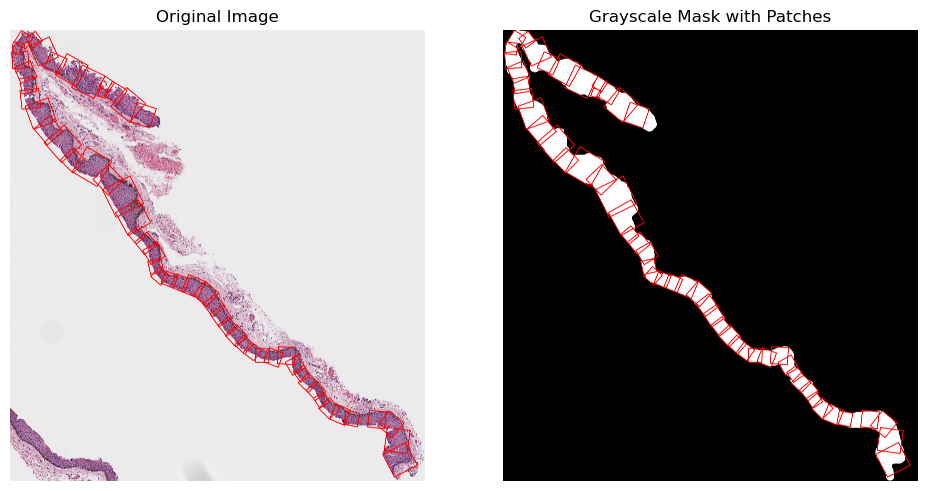

                      Metric        Value
0                num_patches    54.000000
1  total_epithelium_coverage    94.482832
2   background_pixel_percent     6.848042
3                      score    94.216658
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000
('testing_slices\\case_25_match_2_h&e.png', 'testing_slices\\case_25_match_2_h&e.tif')
Sigma of : 23.0


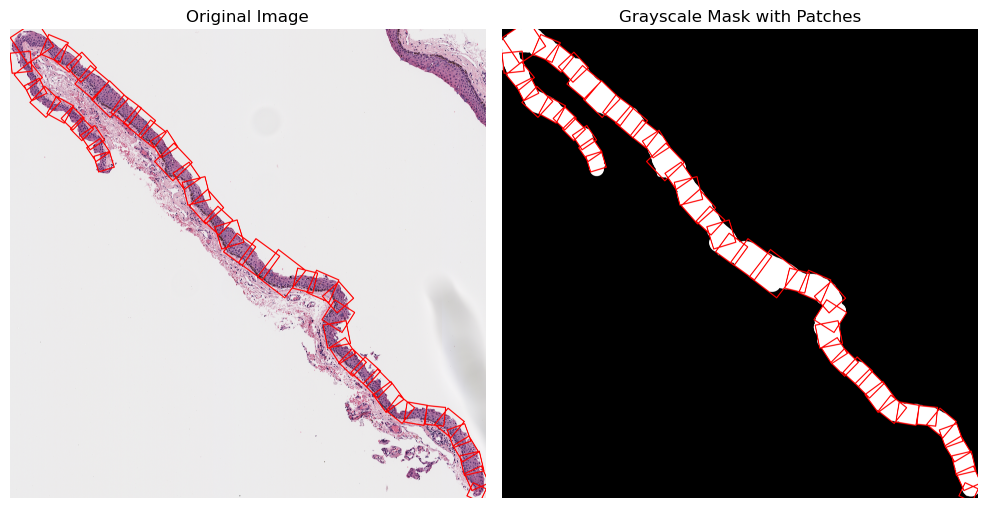

                      Metric        Value
0                num_patches    48.000000
1  total_epithelium_coverage    97.029230
2   background_pixel_percent     4.797376
3                      score    96.663909
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000
('testing_slices\\case_2_match_1_h&e.png', 'testing_slices\\case_2_match_1_h&e.tif')
Sigma of : 28.0


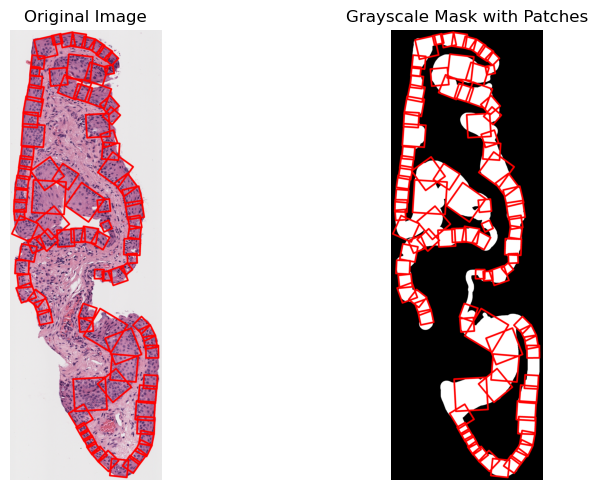

                      Metric        Value
0                num_patches    94.000000
1  total_epithelium_coverage    87.721853
2   background_pixel_percent     7.581525
3                      score    88.661178
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000


In [160]:
# Path to your folder
image_folder = "testing_slices" # put folder path here

# Dictionary to store matches
cases = {}

# Iterate over files in the folder
for filename in os.listdir(image_folder):
    match = re.match(r"case_(\d+)_match_(\d+)_(h&e|melan|sox10).*\.(png|tif)", filename)
    
    if match:
        case_number, match_number, scan_type, extension = match.groups()
        case_number, match_number = int(case_number), int(match_number)  # Convert to int for sorting
        
        if case_number not in cases:
            cases[case_number] = {}

        if match_number not in cases[case_number]:
            cases[case_number][match_number] = {}

        if scan_type not in cases[case_number][match_number]:
            cases[case_number][match_number][scan_type] = {"mask": "None", "slice": "None"}

        if extension == "png":
            cases[case_number][match_number][scan_type]["mask"] = os.path.join(image_folder, filename)
            
        elif extension == "tif":
            cases[case_number][match_number][scan_type]["slice"] = os.path.join(image_folder, filename)

# Build list of tuples (mask, slice), ensuring both exist
matched_pairs = []
masks = []
for case in cases.values():
    for match in case.values():
        for scan in match.values():
            if 'mask' in scan:
                matched_pairs.append((scan['mask'], scan['slice']))


# delete any patches that are already in the directory
empty_folder()

# Run patching and exporting over list of tuples
for i, m in enumerate(matched_pairs, 1):
    print(m)
    image1 = cv2.imread(m[0])
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    Otsu_threshold, epithelium_mask_2D = cv2.threshold(image1_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    metrics, images = patching_export(epithelium_mask_2D, m[0], m[1])  # (binary, slice_name, slice_details) aka (binary image, epithelium annotation png, tif)
    print(metrics)

## Analytical tools

### Visualize tangents

In [145]:
def visualize_tangents(image,contours,normals,tangent_length=200,color=(255,0,0),thickness=30,step=10):
    """
    Visualize tangent vectors along contours.
    """
    result=image.copy()
    
    for contour,contour_normals in zip(contours, normals):
        points=contour.reshape(-1, 2)
        
        for i in range(0,len(points),step):
            tangent=np.array([-contour_normals[i][1], contour_normals[i][0]])  # Rotate normal by 90 degrees
            
            tangent=tangent*tangent_length//2
            
            start_point=tuple((points[i]-tangent).astype(int))
            end_point=tuple((points[i]+tangent).astype(int))
            
            cv2.line(result,start_point,end_point,color,thickness)
    
    return result

In [164]:
m[0]

'testing_slices\\case_25_match_1_h&e.png'

In [141]:
result,contours,final_squares,normals=process_all_contours((m[0]),epithelium_mask_2D,0.2)

Sigma of : 25.0


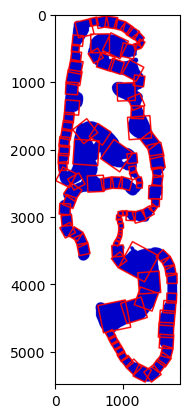

In [135]:
plt.imshow(draw_squares(image1.copy(), final_squares))

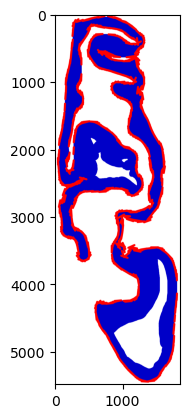

In [97]:
plt.imshow(visualize_tangents(image1.copy(),contours,normals,100,step=20,thickness=30))

### Visualize contours

In [125]:
def contour_viz(contour_to_viz, title = ""):    
    # Creating an image as the same size as the epithelium mask
    blank_image = np.zeros_like(epithelium_mask_2D)

    # Drawing contour on the blank image created above
    contour_drawn = cv2.drawContours(blank_image, contour_to_viz, -1, (255, 0, 0), 20)

    # Visualizing the contours
    plt.imshow(contour_drawn);
    plt.title(title);

Sigma of : 25.0


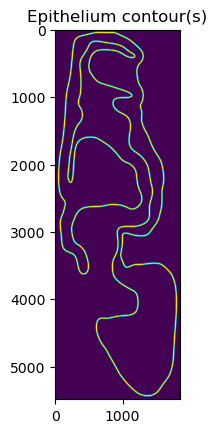

In [146]:
normals,smooth=gaussian_normals(contours)
contour_viz(smooth, "Epithelium contour(s)")